In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from pathlib import Path

In [3]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [27]:
gsize = {}
for p in Path("../results/truth").rglob("*.fai"):
    sample = p.parts[-2]
    size = sum(int(l.split("\t")[1]) for l in p.read_text().splitlines())
    gsize[sample] = size

In [56]:
frames = []
for p in Path("../results/benchmark/call/mutref").rglob("*.tsv"):
    df = pd.read_csv(p, sep="\t")
    sample = p.stem
    model = p.parts[-2].split("_")[-1].split("@")[0]
    mode = p.parts[-4]
    dp = int(p.parts[-5][:-1])
    bp = dp * gsize[sample]
    caller = p.parts[-6]
    df["sample"] = sample
    df["model"] = model
    df["mode"] = mode
    df["depth"] = dp
    df["caller"] = caller
    df["bp"] = bp
    # use rate which is sec/Mbp
    df["rate"] = df["cpu_time"] / df["bp"] * 1e6

    frames.append(df)

In [57]:
df = pd.concat(frames)
df.head()

,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,sample,model,mode,depth,caller,bp,rate
0,27.2634,0:00:27,2430.59,12442.39,1239.43,1443.16,135.55,1.22,147.75,44.61,AMtb_1__202402,hac,duplex,10,nanocaller,44055370,1.012589
0,20.4283,0:00:20,1999.21,11778.52,819.17,1021.98,135.87,3.26,187.94,44.34,ATCC_19119__202309,hac,duplex,10,nanocaller,29192130,1.518903
0,22.5279,0:00:22,1991.00,11561.30,796.44,999.21,136.24,2.96,145.98,39.60,BPH2947__202310,hac,duplex,10,nanocaller,30799530,1.285734
0,29.9515,0:00:29,2424.36,12368.58,1235.61,1438.62,132.41,1.57,150.68,47.30,ATCC_10708__202309,hac,duplex,10,nanocaller,48019670,0.985013
0,31.6126,0:00:31,2485.42,12434.79,1221.24,1424.30,132.45,1.93,159.21,51.22,AJ292__202310,hac,duplex,10,nanocaller,54450050,0.940679


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_51269/749039343.py:30: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(**kwargs, alpha=strip_alpha, edgecolor="gray", linewidth=0.5, ax=mem_ax, jitter=0.2)
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_51269/749039343.py:58: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(**kwargs, alpha=strip_alpha, edgecolor="gray", linewidth=1, ax=rt_ax)


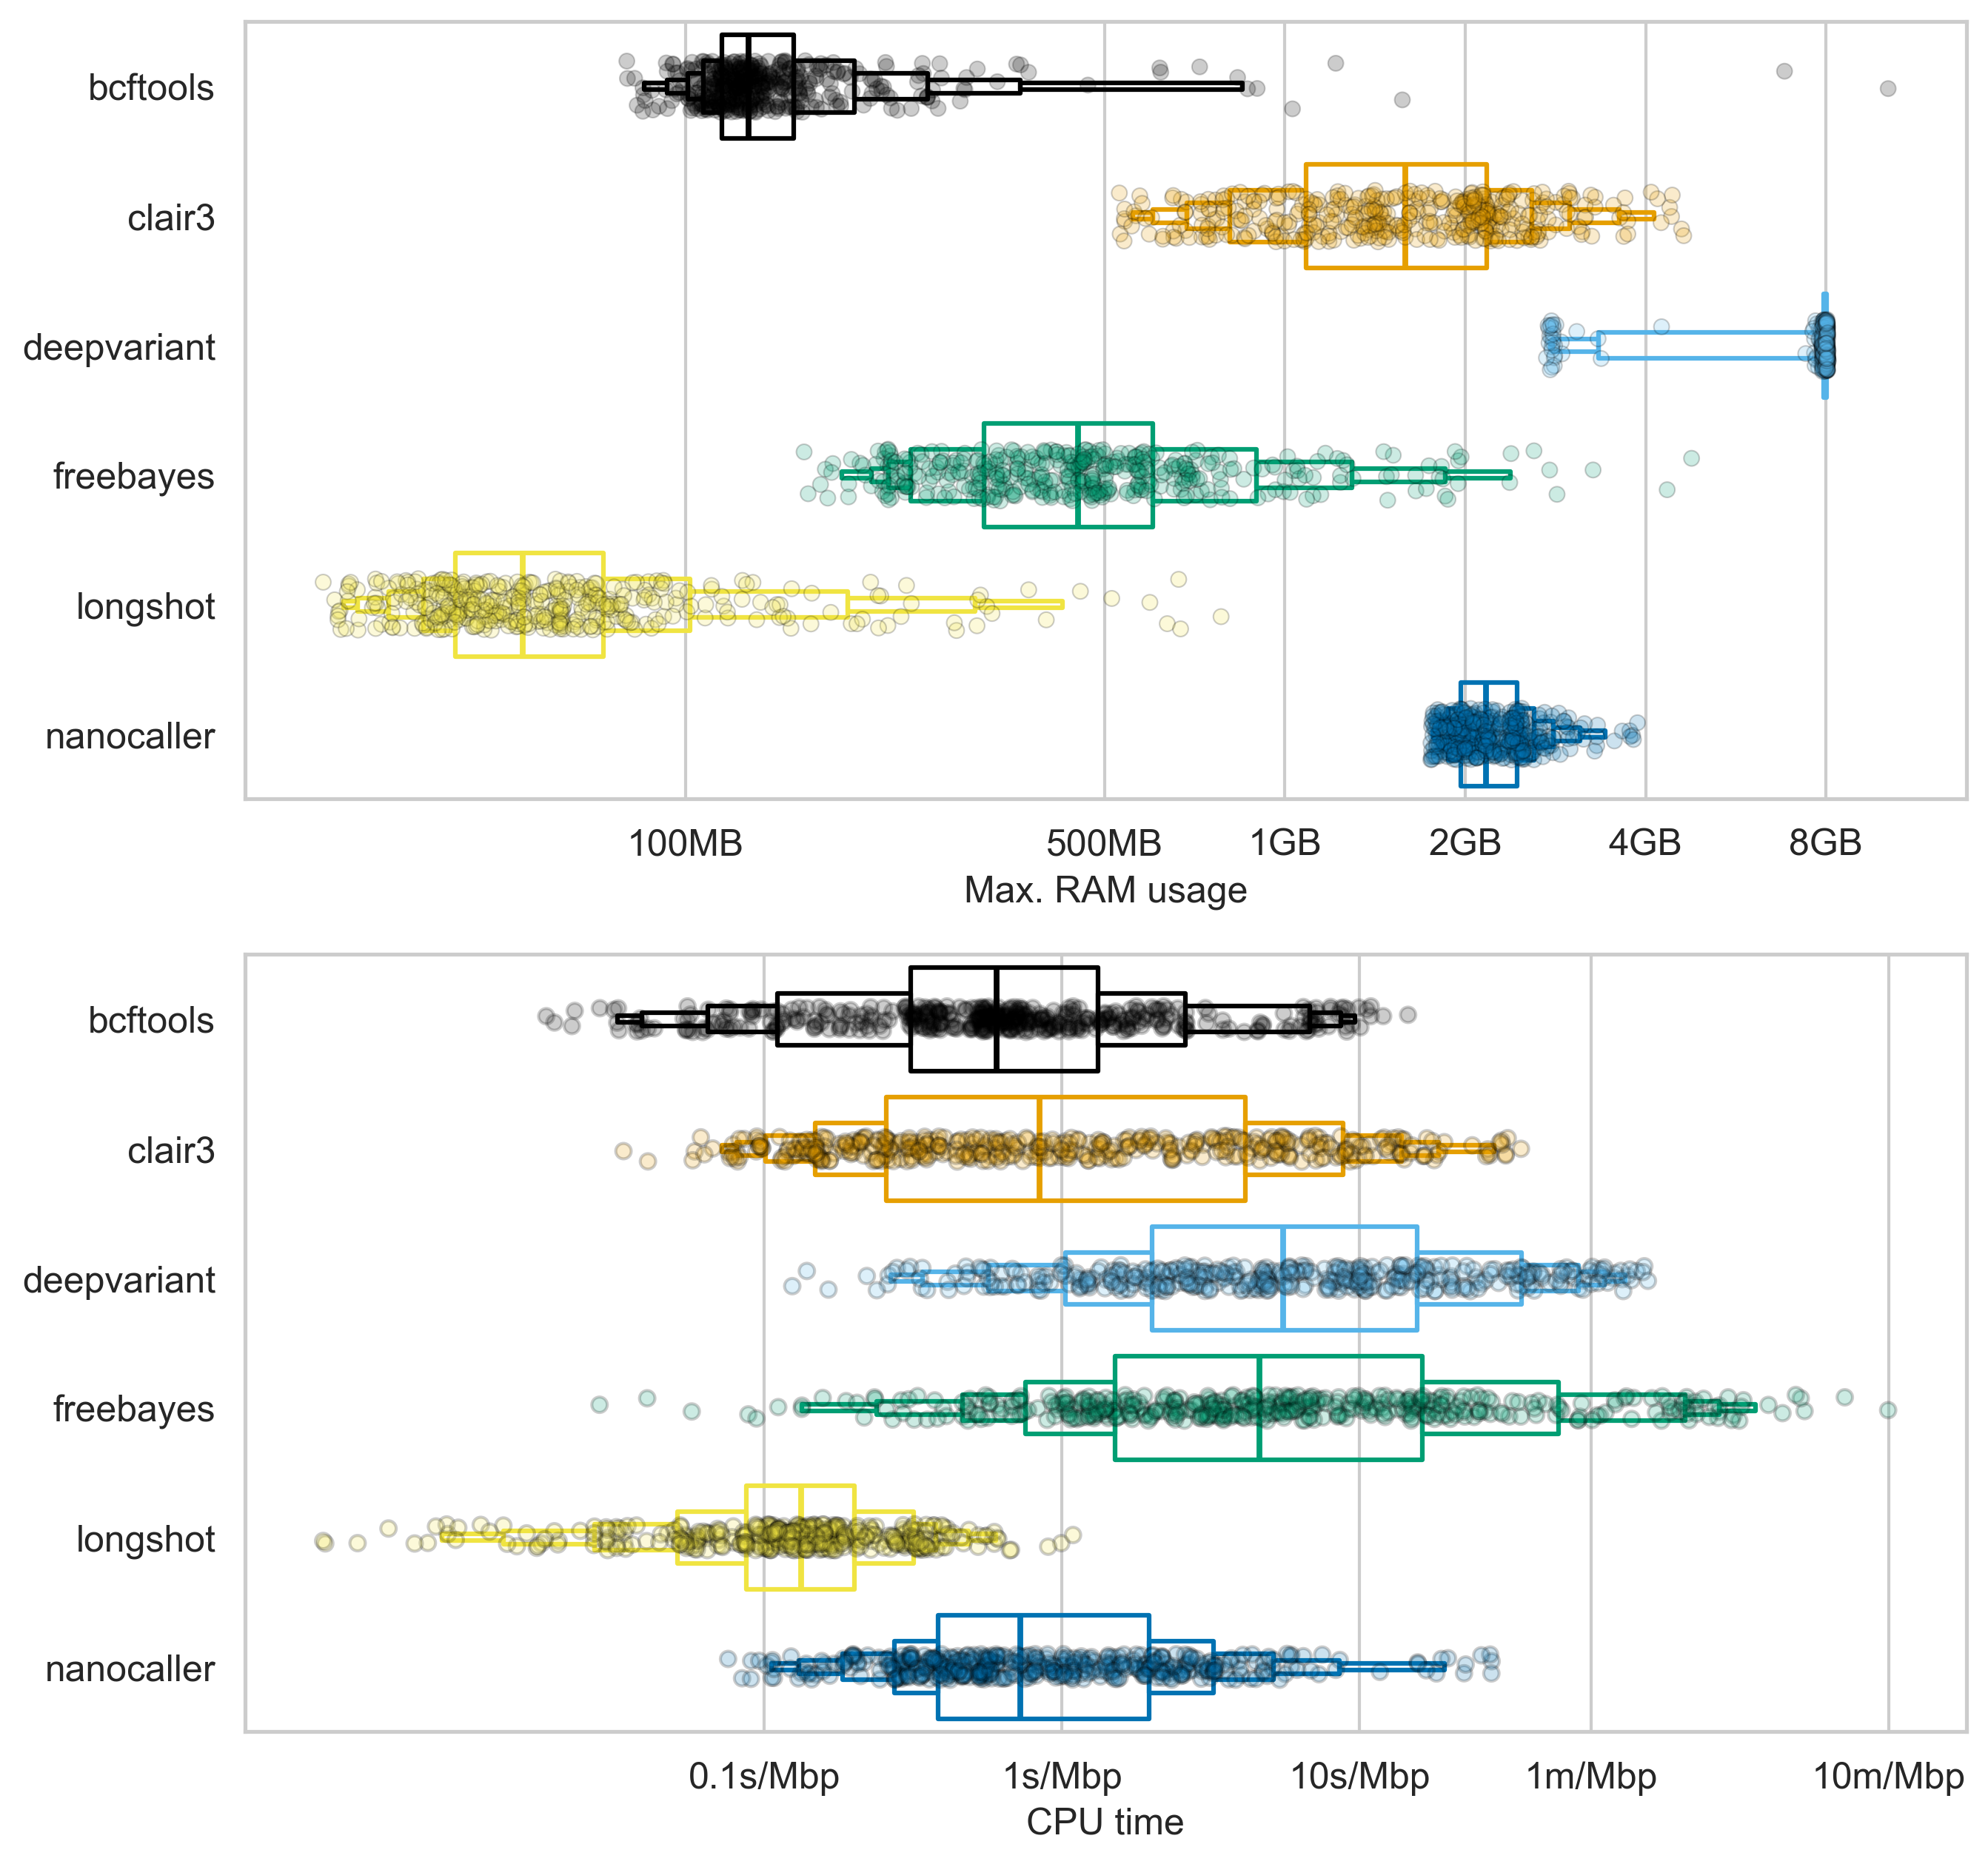

In [96]:
y = "caller"
hue = y
order = sorted(df[y].unique())
palette = cud(n=len(df[hue].unique()))
fig, axes = plt.subplots(nrows=2, figsize=(10, 10), dpi=300, sharey=True)

# plot memory
x = "max_rss"
mem_ax = axes[0]
violin_alpha = 0.2
strip_alpha = 0.2
orient = "h"

kwargs = dict(
    data=df,
    x=x,
    y=y,
    hue=hue,
    order=order,
    hue_order=order,
    palette=palette,
    orient=orient,
    dodge=False,
)
# sns.violinplot(**kwargs, cut=0, inner="quartile", ax=mem_ax)
sns.boxenplot(**kwargs, ax=mem_ax, fill=None, showfliers=False)
# for violin in mem_ax.collections:
    # violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(**kwargs, alpha=strip_alpha, edgecolor="gray", linewidth=0.5, ax=mem_ax, jitter=0.2)
mem_ax.set_xscale("log")
ticks = [
    (100, "100MB"),
    (500, "500MB"),
    (1000, "1GB"),
    (2000, "2GB"),
    # (3000, "3GB"),
    (4000, "4GB"),
    (8000, "8GB"),
]
FS = 12
mem_ax.set_xticks([t[0] for t in ticks])
mem_ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
mem_ax.set_xlabel("Max. RAM usage", fontsize=FS)
mem_ax.set_ylabel("")
mem_ax.tick_params(axis="both", which="major", labelsize=FS)

# plot time (rate)
x = "rate"
rt_ax = axes[1]
kwargs["x"] = x

sns.boxenplot(**kwargs, ax=rt_ax, fill=None, showfliers=False)
# sns.violinplot(**kwargs, cut=0, inner="quartile", ax=rt_ax)
# for violin in rt_ax.collections:
#     violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(**kwargs, alpha=strip_alpha, edgecolor="gray", linewidth=1, ax=rt_ax)

rt_ax.set_xscale("log")
ticks = [
    (0.1, "0.1s/Mbp"),
    (1, "1s/Mbp"),
    (10, "10s/Mbp"),
    (60, "1m/Mbp"),
    (600, "10m/Mbp"),
]
rt_ax.set_xticks([t[0] for t in ticks])
rt_ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
rt_ax.set_xlabel("CPU time", fontsize=FS)
rt_ax.set_ylabel("")
rt_ax.tick_params(axis="both", which="major", labelsize=FS)